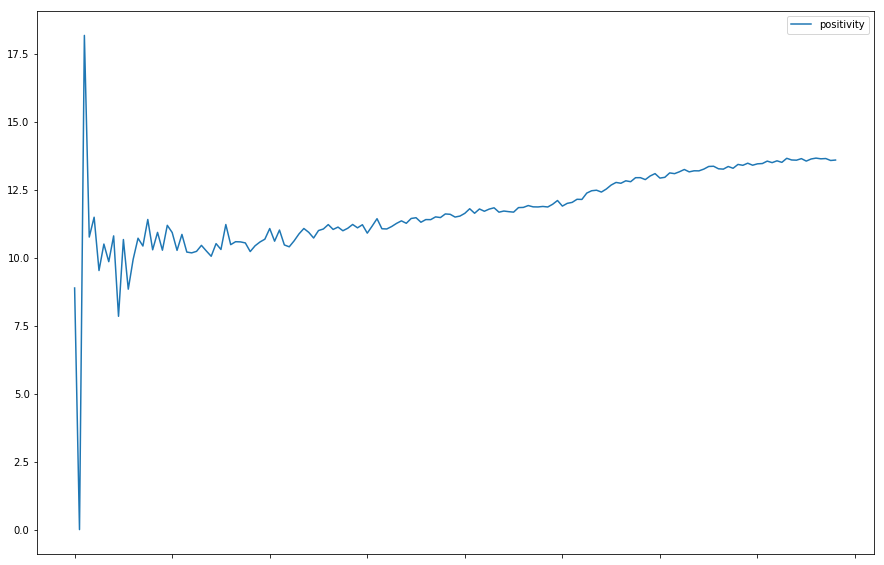

In [28]:
from __future__ import print_function
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.types import *
from pyspark.sql.functions import collect_list
import pandas as pd
import matplotlib.pyplot as plt

# read positivity file
years = []
months = []
positivity_counts = []
positive_words = []

with open("positive-words.txt") as f:
    positive_words = f.read().split()[213:] 

def calculate_positivity(lst):
    count = 0
    total = 0
    for a_review in lst:
        all_words = a_review.split()
        total += len(all_words)
        count += sum([r in positive_words for r in all_words])
    positivity_counts.append((float(count)/float(total)) * 100)
#     for word in lst:
#         if word in positive_words:
#             count = count + 1


    
spark = SparkSession.builder.master("local[4]").appName("Yelp 5 Star Positivity").config("spark.some.config.option", "some-value").getOrCreate()
df = spark.read.json("file:///Users/yashparikh/Project/final_five_star_review.json")

df.createOrReplaceTempView("fiveStar")
sqlDF = spark.sql("SELECT year(date) as year, month(date) as month, text FROM fiveStar month ORDER BY year, month")
totalReviews = sqlDF.groupBy('year', 'month').agg(collect_list('text').alias('all_reviews'))

year_and_month = totalReviews.select('year', 'month').collect()

for row in year_and_month:
    years.append(row['year'])
    months.append(row['month'])
    calculate_positivity(totalReviews.filter((totalReviews["year"] == row['year']) & (totalReviews["month"] == row['month'])).first()['all_reviews'])

positivityDF = pd.DataFrame({'year': years, 'month': months,'positivity': positivity_counts})
positivityDF.set_index(['year', 'month'], inplace=True, drop=True)
# positivityDF.index.values
positivityDF.plot.line(x=positivityDF.index.values, y='positivity', figsize=(15,10))
# totalReviews.groupby().collect()

#totalReviews.filter((totalReviews["year"] == 2004) & (totalReviews["month"] == 10)).first()
# totalReviews = sqlDF.groupby(['year', 'month']).apply(lambda x: "%s" % ' '.join(x['text']))
# totalReviews = totalReviews.to_frame().rename(columns= {0: 'all_reviews'})

# year_and_month = totalReviews.index.values.tolist()
 
# total_count = []
# positive_count = []

# for date in year_and_month:
# 	entire_text = totalReviews.loc[(date)].values.tolist()[0].split(" ")
# 	length = len(entire_text)
# 	total_count.append(length)
	
# 	pos_count = (calculate_positivity(entire_text)/float(length)) * 100
# 	positive_count.append(pos_count)

# totalReviews["pos_count"] = positive_count
# totalReviews.plot.line(x=totalReviews.index, y='pos_count', figsize=(15,10))
# print(totalReviews.loc[(2006,3)].values)